In [1]:
from __future__ import absolute_import, print_function, unicode_literals, division
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
from mallworld import MallWorld

In [37]:
mall_grid = MallWorld.samples["two level"]
task = MallWorld(maze = mall_grid, num_advs=3, 
                 rewards = {"moved":-1, "*":200, "hit-wall":-2, "runinto-people":-30, "stair":0,"stay":-1})

In [38]:
task.reset()
task.visualize()
for i in task.adversaries_position:
    print(task.maze.unflatten_index(i))
    print(i)

#########
#......%#
#.......#
#..#....#
#a.#....#
#.......#
##......#
#I......#
#########

#########
#......%#
#.......#
#..#....#
#..#..a.#
#.......#
##......#
#*a.....#
#########
(1, 4, 6)
123
(1, 7, 2)
146
(0, 4, 1)
37


In [39]:
def show_policy(task, policy):
    for state in range(task.num_states):
        maze_contents = task.maze.get_flat(state)
        row, col = task.maze.unflatten_index(state)
        if maze_contents != '.':
            sym = maze_contents
            plt.text(col + .5, row + .5, sym, fontsize=12)
        else:
            for action, sym in enumerate('^v><'):
                plt.text(col + .5, row + .5, sym, fontsize=12, alpha=policy[state, action])
    plt.axis([0, task.maze.shape[0], task.maze.shape[1], 0]);

In [40]:
def plot_with_errbars(N, data,type="-"):
    x = np.arange(N)
    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    valid = ~np.isnan(mean)
    plt.fill_between(x[valid], (mean-2*std)[valid], (mean+2*std)[valid], color='#d0d0d0')
    plt.plot(x[valid], mean[valid],type)

###SARAR Agent

In [41]:
class SARSAAgent:
    def __init__(self, num_situations, num_actions, epsilon, discount_factor, Q_initial = 0):
        self.num_situations = num_situations
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.learning_rate = 0.1
        self.Q_initial = Q_initial
        self.value_table = np.full((self.num_situations, self.num_actions),self.Q_initial)
        self.reset()
        
    def learning_rate_1_cur_iteration(self,iteration):
        self.learning_rate = 1/iteration
    
    def learning_rate_5_or_cur_iteration(self,iteration):
        self.learning_rate = min(0.5, 10/iteration)
    
    def learning_rate_const(self,a):
        self.learning_rate =a

    def reset(self):
        self.last_state = None
        self.last_action = None
        self.value_table.fill(0)

    def interact(self, reward, next_state,next_state_is_terminal):
        
        # Handle start of episode.
        if reward is None:
            self.last_state = next_state
            self.last_action = np.random.random_integers(0,self.num_actions-1)
            return self.last_action    
        
        # Handle completion of episode.
        if next_state_is_terminal:
            delta = reward -self.value_table[self.last_state, self.last_action]
            self.value_table[self.last_state, self.last_action] += self.learning_rate * delta
            return np.random.random_integers(0,self.num_actions-1) 

        # Update value function.        
        next_action = self.value_table[next_state, :].argmax()  
        if(np.random.uniform(0,1) < epsilon):
            next_action = np.random.random_integers(0,self.num_actions-1)        
        
        delta = reward + discount_factor * self.value_table[next_state, next_action] - self.value_table[self.last_state, self.last_action]
        self.value_table[self.last_state, self.last_action] += self.learning_rate * delta
        if  (self.last_state == 97):
            self.value_table[16, self.last_action] = self.value_table[self.last_state, self.last_action]
            
        self.last_state = next_state
        self.last_action = next_action
        return self.last_action

### Q-Learning Agent

In [72]:
class QLearnAgent:
    def __init__(self, num_situations, num_actions, epsilon, discount_factor, Q_initial = 0):
        self.num_situations = num_situations
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.learning_rate = 0.1
        self.Q_initial = Q_initial
        self.value_table = np.full((self.num_situations, self.num_actions),self.Q_initial)
        self.reset()
        
    def learning_rate_1_cur_iteration(self,iteration):
        self.learning_rate = 1/iteration
    
    def learning_rate_5_or_cur_iteration(self,iteration):
        self.learning_rate = min(0.5, 10/iteration)
    
    def learning_rate_const(self,a):
        self.learning_rate =a

    def reset(self):
        self.last_state = None
        self.last_action = None
        self.value_table.fill(0)

    def interact(self, reward, next_state,next_state_is_terminal):
        
        # Handle start of episode.
        if reward is None:
            self.last_state = next_state
            self.last_action = np.random.random_integers(0,self.num_actions-1)
            return self.last_action    
        
        # Handle completion of episode.
        if next_state_is_terminal:
            delta = reward -self.value_table[self.last_state, self.last_action]
            self.value_table[self.last_state, self.last_action] += self.learning_rate * delta
            return np.random.random_integers(0,self.num_actions-1) 

        # Update value function.        
        next_action = self.value_table[next_state, :].argmax()  
        if(np.random.uniform(0,1) < epsilon):
            next_action = np.random.random_integers(0,self.num_actions-1)
            
        delta = reward + discount_factor * self.value_table[next_state, self.value_table[next_state, :].argmax()] - self.value_table[self.last_state, self.last_action]
        self.value_table[self.last_state, self.last_action] += self.learning_rate * delta
        
        if  (self.last_state == 97):
            self.value_table[16, self.last_action] = self.value_table[self.last_state, self.last_action]
            
        self.last_state = next_state
        self.last_action = next_action
        return self.last_action

### People randomly Walking

In [55]:
def run_trial_ss_or_ql_rand(agent, MIN_ITERATIONS,MIN_EPISODES,rewards_by_iteration, rewards_by_episode,hits_by_iteration, hits_by_episode, learning_rate="option_3"):
    iteration = episode = 0
    agent.reset()

    while iteration < MIN_ITERATIONS or episode < MIN_EPISODES:
        # Initialize the episode.
        task.reset()
        all_states = task.observe()
        agent_state = all_states[0]
        situation = int(task.current_situation[0])
        reward = None
        hit = None
        cumulative_reward = 0
        cumulative_hit = 0

        while iteration < MIN_ITERATIONS or episode < MIN_EPISODES:
            if(learning_rate == "option_1"):
                agent.learning_rate_1_cur_iteration((iteration+1))
            if(learning_rate == "option_2"):
                agent.learning_rate_5_or_cur_iteration((iteration+1))
            if(learning_rate == "option_3"):
                agent.learning_rate_const(0.4)
            action = agent.interact(reward, situation, task.is_terminal(agent_state))
       
            if task.is_terminal(agent_state):
                # End of episode (happens after interaction so agent can learn from final reward).
                break

            # Take action A, observe R, S'.
            all_states, reward, hit = task.perform_action_adversary_rand(action)
            agent_state = all_states[0]
            situation = int(task.current_situation[0])
            # Log rewards.
            if iteration < MIN_ITERATIONS:
                rewards_by_iteration[iteration] = reward
                hits_by_iteration[iteration] = hit
            cumulative_reward += reward
            cumulative_hit += hit
            iteration += 1

        if episode < MIN_EPISODES:
            rewards_by_episode[episode] = cumulative_reward
            hits_by_episode[episode] = cumulative_hit
        episode += 1

### Test SARSA

In [56]:
p1_agent_sarsa = SARSAAgent(2535462, num_actions=task.num_actions, epsilon = 0.1, discount_factor = 0.95)

In [58]:
MIN_ITERATIONS = 40000
MIN_EPISODES = 600
epsilon = 0.1
discount_factor = 0.95

numt=2

#run learner for 50 trials
p1_ss_res0 = np.zeros((1,numt,MIN_ITERATIONS))
p1_ss_res1 = np.zeros((1,numt,MIN_EPISODES))
h1_ss_res0 = np.zeros((1,numt,MIN_ITERATIONS))
h1_ss_res1 = np.zeros((1,numt,MIN_EPISODES))

rewards_by_iteration_ss = np.zeros(MIN_ITERATIONS)
rewards_by_episode_ss = np.zeros(MIN_EPISODES)
hits_by_iteration_ss = np.zeros(MIN_ITERATIONS)
hits_by_episode_ss = np.zeros(MIN_EPISODES)

begin = time.time()
for t in xrange(0,numt):
    run_trial_ss_or_ql_rand(p1_agent_sarsa,MIN_ITERATIONS,MIN_EPISODES,rewards_by_iteration_ss, rewards_by_episode_ss,hits_by_iteration_ss, hits_by_episode_ss,learning_rate="option_3")
    p1_ss_res0[0,t,:] = rewards_by_iteration_ss
    p1_ss_res1[0,t,:] = rewards_by_episode_ss
    h1_ss_res0[0,t,:] = hits_by_iteration_ss
    h1_ss_res1[0,t,:] = hits_by_episode_ss
print(time.time()-begin)

184.464249849


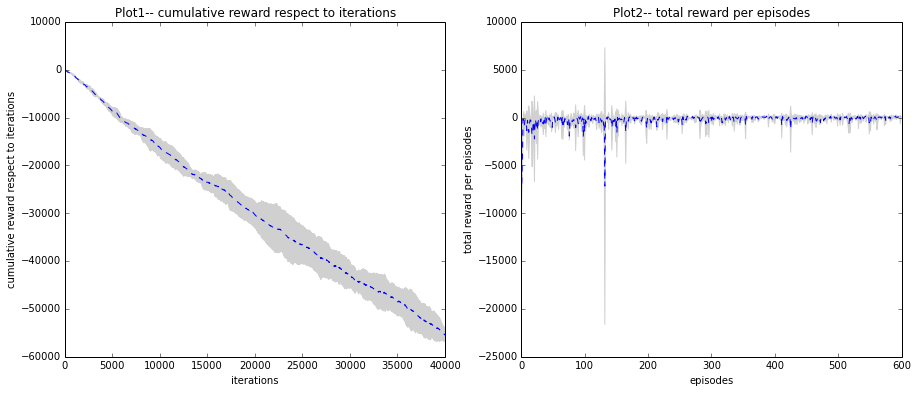

In [59]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
cum_reward_iter = p1_ss_res0[0].cumsum(axis = 1)
plot_with_errbars(MIN_ITERATIONS,cum_reward_iter,'b--')

plt.xlabel('iterations')
plt.ylabel('cumulative reward respect to iterations')
plt.xlim([0,MIN_ITERATIONS])
plt.title('Plot1-- cumulative reward respect to iterations')

plt.subplot(1,2,2)
plot_with_errbars(MIN_EPISODES,p1_ss_res1[0],'b--')

plt.xlabel('episodes')
plt.ylabel('total reward per episodes')
plt.xlim([0,MIN_EPISODES])
plt.title('Plot2-- total reward per episodes')

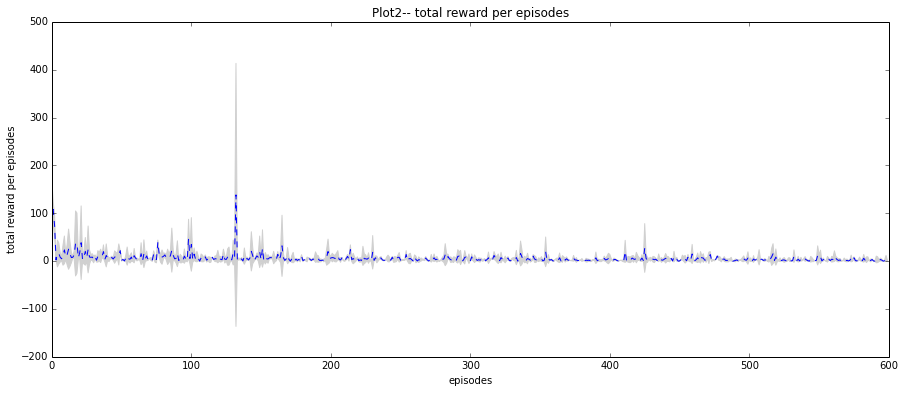

In [60]:
plt.figure(figsize=(15,6))
plot_with_errbars(MIN_EPISODES,h1_ss_res1[0],'b--')

plt.xlabel('episodes')
plt.ylabel('total reward per episodes')
plt.xlim([0,MIN_EPISODES])
plt.title('Plot2-- total reward per episodes')

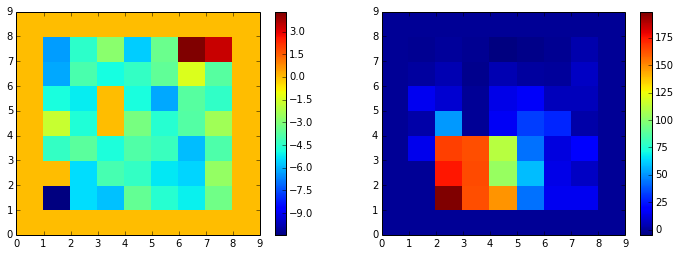

In [61]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.pcolormesh(p1_agent_sarsa.value_table[:81].max(axis=1).reshape(task.maze.shape[1:])[::-1,:])
plt.colorbar();

plt.subplot(1,2,2)
plt.pcolormesh(p1_agent_sarsa.value_table[81:162].max(axis=1).reshape(task.maze.shape[1:])[::-1,:])
plt.colorbar();

### Test QLearing

In [70]:
p1_agent_ql = QLearnAgent(2535462, num_actions=task.num_actions, epsilon = 0.1, discount_factor = 0.95)

In [ ]:
MIN_ITERATIONS = 40
MIN_EPISODES = 2
epsilon = 0.1
discount_factor = 0.95

numt=2

#run learner for 50 trials
p1_ql_res0 = np.zeros((1,numt,MIN_ITERATIONS))
p1_ql_res1 = np.zeros((1,numt,MIN_EPISODES))
h1_ql_res0 = np.zeros((1,numt,MIN_ITERATIONS))
h1_ql_res1 = np.zeros((1,numt,MIN_EPISODES))

rewards_by_iteration_ql = np.zeros(MIN_ITERATIONS)
rewards_by_episode_ql = np.zeros(MIN_EPISODES)
hits_by_iteration_ql = np.zeros(MIN_ITERATIONS)
hits_by_episode_ql = np.zeros(MIN_EPISODES)

begin = time.time()
for t in xrange(0,numt):
    run_trial_ss_or_ql_rand(p1_agent_ql,MIN_ITERATIONS,MIN_EPISODES,rewards_by_iteration_ql, rewards_by_episode_ql,hits_by_iteration_ql, hits_by_episode_ql,learning_rate="option_3")
    p1_ql_res0[0,t,:] = rewards_by_iteration_ql
    p1_ql_res1[0,t,:] = rewards_by_episode_ql
    h1_ql_res0[0,t,:] = hits_by_iteration_ql
    h1_ql_res1[0,t,:] = hits_by_episode_ql
print(time.time()-begin)

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
cum_reward_iter = p1_ql_res0[0].cumsum(axis = 1)
plot_with_errbars(MIN_ITERATIONS,cum_reward_iter,'b--')

plt.xlabel('iterations')
plt.ylabel('cumulative reward respect to iterations')
plt.xlim([0,MIN_ITERATIONS])
plt.title('Plot1-- cumulative reward respect to iterations')

plt.subplot(1,2,2)
plot_with_errbars(MIN_EPISODES,p1_ql_res1[0],'b--')

plt.xlabel('episodes')
plt.ylabel('total reward per episodes')
plt.xlim([0,MIN_EPISODES])
plt.title('Plot2-- total reward per episodes')

In [ ]:
plt.figure(figsize=(15,6))
plot_with_errbars(MIN_EPISODES,h1_ql_res1[0],'b--')

plt.xlabel('episodes')
plt.ylabel('total reward per episodes')
plt.xlim([0,MIN_EPISODES])
plt.title('Plot2-- total reward per episodes')

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.pcolormesh(p1_agent_ql.value_table[:81].max(axis=1).reshape(task.maze.shape[1:])[::-1,:])
plt.colorbar();

plt.subplot(1,2,2)
plt.pcolormesh(p1_agent_ql.value_table[81:162].max(axis=1).reshape(task.maze.shape[1:])[::-1,:])
plt.colorbar();

### People walking with policy:

### SARSA

In [43]:
def run_trial_ss_or_ql_policy(agent, MIN_ITERATIONS,MIN_EPISODES,rewards_by_iteration, rewards_by_episode,hits_by_iteration, hits_by_episode, learning_rate="option_3"):
    iteration = episode = 0
    agent.reset()

    while iteration < MIN_ITERATIONS or episode < MIN_EPISODES:
        # Initialize the episode.
        task.reset()
        all_states = task.observe()
        agent_state = all_states[0]
        situation = int(task.current_situation[0])
        reward = None
        hit = None
        cumulative_reward = 0
        cumulative_hit = 0

        while iteration < MIN_ITERATIONS or episode < MIN_EPISODES:
            if(learning_rate == "option_1"):
                agent.learning_rate_1_cur_iteration((iteration+1))
            if(learning_rate == "option_2"):
                agent.learning_rate_5_or_cur_iteration((iteration+1))
            if(learning_rate == "option_3"):
                agent.learning_rate_const(0.4)
            action = agent.interact(reward, situation, task.is_terminal(agent_state))
       
            if task.is_terminal(agent_state):
                # End of episode (happens after interaction so agent can learn from final reward).
                break

            # Take action A, observe R, S'.
            all_states, reward, hit = task.perform_action_adversary_w_policy(action)
            agent_state = all_states[0]
            situation = int(task.current_situation[0])
            # Log rewards.
            if iteration < MIN_ITERATIONS:
                rewards_by_iteration[iteration] = reward
                hits_by_iteration[iteration] = hit
            cumulative_reward += reward
            cumulative_hit += hit
            iteration += 1

        if episode < MIN_EPISODES:
            rewards_by_episode[episode] = cumulative_reward
            hits_by_episode[episode] = cumulative_hit
        episode += 1

In [44]:
p2_agent_sarsa = SARSAAgent(2535462, num_actions=task.num_actions, epsilon = 0.1, discount_factor = 0.95)

In [45]:
MIN_ITERATIONS = 40000
MIN_EPISODES = 600
epsilon = 0.1
discount_factor = 0.95

numt=3

#run learner for 50 trials
p2_ss_res0 = np.zeros((1,numt,MIN_ITERATIONS))
p2_ss_res1 = np.zeros((1,numt,MIN_EPISODES))
h2_ss_res0 = np.zeros((1,numt,MIN_ITERATIONS))
h2_ss_res1 = np.zeros((1,numt,MIN_EPISODES))

rewards_by_iteration_ss = np.zeros(MIN_ITERATIONS)
rewards_by_episode_ss = np.zeros(MIN_EPISODES)
hits_by_iteration_ss = np.zeros(MIN_ITERATIONS)
hits_by_episode_ss = np.zeros(MIN_EPISODES)

begin = time.time()
for t in xrange(0,numt):
    run_trial_ss_or_ql_policy(p2_agent_sarsa,MIN_ITERATIONS,MIN_EPISODES,rewards_by_iteration_ss, rewards_by_episode_ss,hits_by_iteration_ss, hits_by_episode_ss,learning_rate="option_3")
    p2_ss_res0[0,t,:] = rewards_by_iteration_ss
    p2_ss_res1[0,t,:] = rewards_by_episode_ss
    h2_ss_res0[0,t,:] = hits_by_iteration_ss
    h2_ss_res1[0,t,:] = hits_by_episode_ss
print(time.time()-begin)

161.687557936


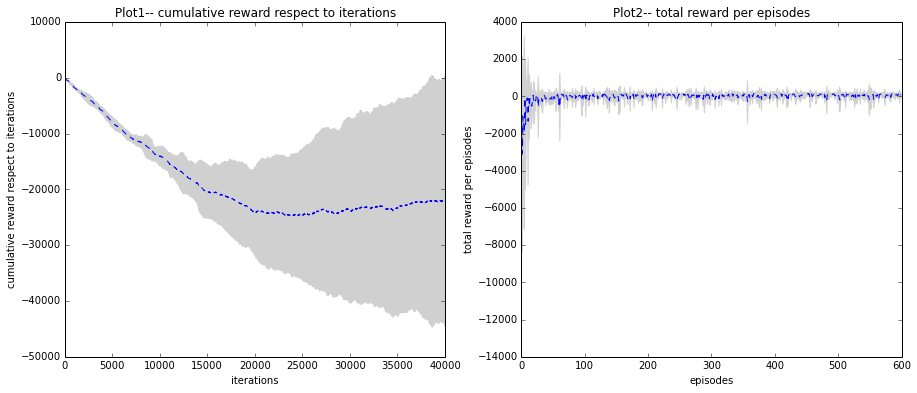

In [46]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
cum_reward_iter = p2_ss_res0[0].cumsum(axis = 1)
plot_with_errbars(MIN_ITERATIONS,cum_reward_iter,'b--')

plt.xlabel('iterations')
plt.ylabel('cumulative reward respect to iterations')
plt.xlim([0,MIN_ITERATIONS])
plt.title('Plot1-- cumulative reward respect to iterations')

plt.subplot(1,2,2)
plot_with_errbars(MIN_EPISODES,p2_ss_res1[0],'b--')

plt.xlabel('episodes')
plt.ylabel('total reward per episodes')
plt.xlim([0,MIN_EPISODES])
plt.title('Plot2-- total reward per episodes')

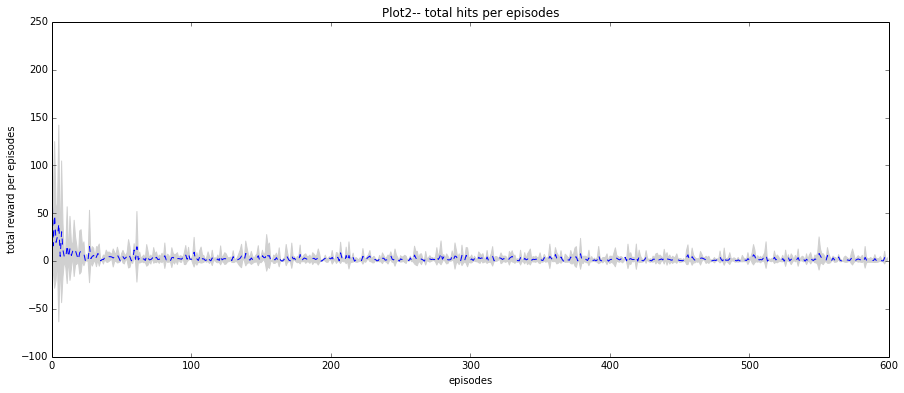

In [52]:
plt.figure(figsize=(15,6))

plot_with_errbars(MIN_EPISODES,h2_ss_res1[0],'b--')

plt.xlabel('episodes')
plt.ylabel('total reward per episodes')
plt.xlim([0,MIN_EPISODES])
plt.title('Plot2-- total hits per episodes')

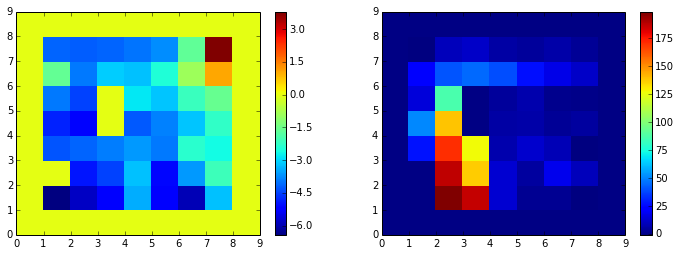

In [28]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.pcolormesh(p2_agent_sarsa.value_table[:81].max(axis=1).reshape(task.maze.shape[1:])[::-1,:])
plt.colorbar();

plt.subplot(1,2,2)
plt.pcolormesh(p2_agent_sarsa.value_table[81:162].max(axis=1).reshape(task.maze.shape[1:])[::-1,:])
plt.colorbar();

### QLearning

In [68]:
p2_agent_ql = QLearnAgent(2535462, num_actions=task.num_actions, epsilon = 0.1, discount_factor = 0.95)

In [69]:
MIN_ITERATIONS = 400
MIN_EPISODES = 60
epsilon = 0.1
discount_factor = 0.95

numt=3

#run learner for 50 trials
p2_ql_res0 = np.zeros((1,numt,MIN_ITERATIONS))
p2_ql_res1 = np.zeros((1,numt,MIN_EPISODES))
h2_ql_res0 = np.zeros((1,numt,MIN_ITERATIONS))
h2_ql_res1 = np.zeros((1,numt,MIN_EPISODES))

rewards_by_iteration_ql = np.zeros(MIN_ITERATIONS)
rewards_by_episode_ql = np.zeros(MIN_EPISODES)
hits_by_iteration_ql = np.zeros(MIN_ITERATIONS)
hits_by_episode_ql = np.zeros(MIN_EPISODES)

begin = time.time()
for t in xrange(0,numt):
    run_trial_ss_or_ql_policy(p2_agent_ql,MIN_ITERATIONS,MIN_EPISODES,rewards_by_iteration_ql, rewards_by_episode_ql,hits_by_iteration_ql, hits_by_episode_ql,learning_rate="option_3")
    p2_ql_res0[0,t,:] = rewards_by_iteration_ql
    p2_ql_res1[0,t,:] = rewards_by_episode_ql
    h2_ql_res0[0,t,:] = hits_by_iteration_ql
    h2_ql_res1[0,t,:] = hits_by_episode_ql
print(time.time()-begin)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
cum_reward_iter = p2_ql_res0[0].cumsum(axis = 1)
plot_with_errbars(MIN_ITERATIONS,cum_reward_iter,'b--')

plt.xlabel('iterations')
plt.ylabel('cumulative reward respect to iterations')
plt.xlim([0,MIN_ITERATIONS])
plt.title('Plot1-- cumulative reward respect to iterations')

plt.subplot(1,2,2)
plot_with_errbars(MIN_EPISODES,p2_ql_res1[0],'b--')

plt.xlabel('episodes')
plt.ylabel('total reward per episodes')
plt.xlim([0,MIN_EPISODES])
plt.title('Plot2-- total reward per episodes')

In [ ]:
plt.figure(figsize=(15,6))
plot_with_errbars(MIN_EPISODES,h2_ql_res1[0],'b--')

plt.xlabel('episodes')
plt.ylabel('total reward per episodes')
plt.xlim([0,MIN_EPISODES])
plt.title('Plot2-- total reward per episodes')

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.pcolormesh(p2_agent_ql.value_table[:81].max(axis=1).reshape(task.maze.shape[1:])[::-1,:])
plt.colorbar();

plt.subplot(1,2,2)
plt.pcolormesh(p2_agent_ql.value_table[81:162].max(axis=1).reshape(task.maze.shape[1:])[::-1,:])
plt.colorbar();

### RMAX Agent

In [119]:
class RMAXAgent:
    def __init__(self, num_states, num_actions, discount_factor, min_visit):
        self.num_states = num_states
        self.num_actions = num_actions
        self.discount_factor = discount_factor
        self.transition_observations = np.zeros((num_states+1, num_actions, num_states+1))               
        self.min_visit = min_visit
        self.update_flag = 0
        
        self.Reward = np.full((self.num_states+1, self.num_actions, self.num_states+1), task.get_max_reward()) 
        
        self.mdp = np.full((self.num_states+1, self.num_actions, self.num_states+1), 0)  
        self.mdp[:,:,self.num_states] = 1  
        
        self.policy = np.zeros(self.num_states)  
        self.update_MDP()
        self.value_iteration()
        self.reset()

    def reset(self):
        self.update = 0
        self.last_state = None
        self.last_action = None
        
    def value_iteration(self):
        v = np.zeros(self.num_states+1) # Initialize value of state to 0
        while True:
            delta = 0
            for s in xrange(self.num_states+1):
                temp = v[s]
                v[s] = np.max((self.mdp[s]*(self.Reward[s]+self.discount_factor*v)).sum(axis=1))   
                delta = max(delta, abs(temp-v[s]))
            if delta<0.01: break 
        p = np.zeros(self.num_states+1)
        for s in xrange(self.num_states+1):
            p[s] = np.argmax((self.mdp[s]*(self.Reward[s]+self.discount_factor*v)).sum(axis=1))        
        self.policy = p
    
    def update_MDP(self):
        for s in xrange(self.num_states):
            for a in xrange(self.num_actions):
                if self.transition_observations[s,a].sum() >= self.min_visit:
                    self.mdp[s,a] = 0
                    for s_p in xrange(self.num_states):
                        self.mdp[s,a,s_p] = self.transition_observations[s,a,s_p]/self.transition_observations[s,a].sum()

    def interact(self, reward, next_state, next_state_is_terminal, update_flag):
         # Handle start of episode.
        if reward is None:
            self.last_state = next_state
            self.last_action = self.policy[self.last_state]
            return self.last_action    
        
        # Handle completion of episode.
        if next_state_is_terminal:
            if(self.transition_observations[self.last_state, self.last_action, next_state]==0):           
                self.Reward[self.last_state, self.last_action, next_state] = reward            
                
            if(self.transition_observations[self.last_state,self.last_action].sum()< self.min_visit):
                self.transition_observations[self.last_state,self.last_action,next_state] +=1
                if(self.transition_observations[self.last_state,self.last_action].sum()== self.min_visit):
                    for s_p in xrange(self.num_states):
                        self.mdp[self.last_state,self.last_action,s_p] = self.transition_observations[self.last_state,self.last_action,s_p]/self.transition_observations[self.last_state,self.last_action].sum()
                    self.value_iteration()

            self.last_state = next_state
            return self.last_action      
        
        # update the optimal policy for every 50 iterations
        if(update_flag==1):
            self.update_MDP()
            self.value_iteration()
            
        if(self.transition_observations[self.last_state, self.last_action, next_state]==0):           
            self.Reward[self.last_state, self.last_action, next_state] = reward            
        next_action = self.policy[next_state]
        
        if(self.transition_observations[self.last_state,self.last_action].sum()< self.min_visit):
            self.transition_observations[self.last_state,self.last_action,next_state] +=1
            if(self.transition_observations[self.last_state,self.last_action].sum()== self.min_visit):
                for s_p in xrange(self.num_states):
                    self.mdp[self.last_state,self.last_action,s_p] = self.transition_observations[self.last_state,self.last_action,s_p]/self.transition_observations[self.last_state,self.last_action].sum()
                self.value_iteration()

        self.last_state = next_state
        self.last_action = next_action
        return self.last_action

In [17]:
def run_trial_rmax_or_ts(agent, rewards_by_iteration, rewards_by_episode, T):
    iteration = episode = 0
    agent.reset()
    while ((iteration < MIN_ITERATIONS) or (episode < MIN_EPISODES)):
        # Initialize the episode.
        task.reset()
        all_states = task.observe()
        agent_state = all_states[0]
        situation = int(task.current_situation[0])
        reward = None
        cumulative_reward = 0
        
        while ((iteration < MIN_ITERATIONS) or (episode < MIN_EPISODES)):
            if not iteration%T:
                update_flag = 1
            # Tell the agent what happened and ask for a next action.            
            action = agent.interact(reward, situation, task.is_terminal(agent_state),update_flag)

            if task.is_terminal(agent_state):   
                break

            # Take action A, observe R, S'.
            all_states, reward = task.perform_action_adversary_rand(action)
            agent_state = all_states[0]
            situation = int(task.current_situation[0])
            
            # Log rewards.
            if iteration < MIN_ITERATIONS:
                rewards_by_iteration[iteration] = reward
            cumulative_reward += reward
            iteration += 1
            update_flag=0

        if episode < MIN_EPISODES:
            rewards_by_episode[episode] = cumulative_reward
        episode += 1

In [18]:
agent_rmax = RMAXAgent(2535462, num_actions=task.num_actions, discount_factor = 0.95, min_visit=5)

NameError: name 'RMAXAgent' is not defined